# TDE 2
## Alunos: Eduardo Eiji Goto, Gustavo Hammerschmidt, João Vitor Andrioli de Souza

In [2]:
DIMENSIONS = (128,128)

### Imports

In [3]:
!wget https://www.inf.ufpr.br/aghochuli/dataset3.zip -O dataset3.zip
!unzip dataset3.zip

--2021-10-11 01:48:15--  https://www.inf.ufpr.br/aghochuli/dataset3.zip
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35758483 (34M) [application/zip]
Saving to: ‘dataset3.zip’

dataset3.zip        100%[===================>]  34.10M  15.4MB/s    in 2.2s    

2021-10-11 01:48:18 (15.4 MB/s) - ‘dataset3.zip’ saved [35758483/35758483]

Archive:  dataset3.zip
replace dataset3/5_1477189488.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset3/5_1477189488.jpg  
  inflating: dataset3/100_1477280538.jpg  
  inflating: dataset3/50_1477282872.jpg  
  inflating: dataset3/10_1477147452.jpg  
  inflating: dataset3/50_1477283088.jpg  
  inflating: dataset3/10_1477288506.jpg  
  inflating: dataset3/10_1477288476.jpg  
  inflating: dataset3/100_1477281726.jpg  
  inflating: dataset3/5_1477290534.jpg  


In [4]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import io, util
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import threshold_yen, threshold_otsu, threshold_local, median
from skimage.feature import local_binary_pattern
from skimage.morphology import label, closing, square
from skimage.measure import regionprops
from skimage.draw import rectangle_perimeter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### Funções

In [5]:
def print_count(c1, c2):
    print('Contagem de elementos não nulos: {x} / {y}\n'.format(x = c1.count(), y = c2.count()))

def try_resize(img, dim):
    try:
        return resize(img, dim, anti_aliasing=True)
    except:
        return np.nan

In [6]:
def recortar_aux(img, rect):
    return img[rect[0]:rect[2],rect[1]:rect[3]]

def recortar(img, rect):
    try:
        return recortar_aux(img,rect)
    except:
        return np.nan

In [7]:
def mask_aux(img, rect, roi):
    mask = np.zeros([img.shape[0],img.shape[1]])

    mask[rect[0]:rect[2],rect[1]:rect[3]] += roi

    mask = mask.clip(max=1)

    return mask

def get_mask(img, rect, roi):
    try:
        return mask_aux(img, rect, roi)
    except:
        return np.nan

In [8]:
def img_to_bin(image):

    hsv = rgb2hsv(image)  
    channel_s = hsv[:,:,1]

    channel_filtered = median(channel_s, np.ones((3, 3)))

    block_size = 20
    local_thresh = threshold_otsu(channel_filtered, block_size)
    binary_s = channel_filtered > local_thresh

    return util.img_as_ubyte(binary_s)

def bbox(image):
    
    binary = image #img_to_bin(image)
    
    # label image regions
    label_image = label(binary)
    r = regionprops(label_image)
  
    for region in r:
    
        # skip small images
        if region['Area'] < 50:
            continue
        
        # draw rectangle around segmented coins    
        rect = region['BoundingBox']
        
        ratio = 0
        if  abs(rect[2] - rect[0]) != 0:
            ratio = abs(rect[3] - rect[1]) / abs(rect[2] - rect[0])
        
        #Eliminating non squared bbox 
        if not (0.85 < ratio < 1.15):         
            continue
        
        #roi = recortar(binary, rect) #binary[rect[0]:rect[2],rect[1]:rect[3]]

        #binary_list.append(binary)

        return rect

### Montar DataFrame

In [9]:
%%time

imgs = []

for img_path in os.listdir('./dataset3/'):
    imgs.append([io.imread('./dataset3/' + img_path),img_path])  
print(len(imgs),"images loaded\n")

1000 images loaded

CPU times: user 5.09 s, sys: 813 ms, total: 5.9 s
Wall time: 5.91 s


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ROTULO    1000 non-null   int64 
 1   ORIGINAL  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB




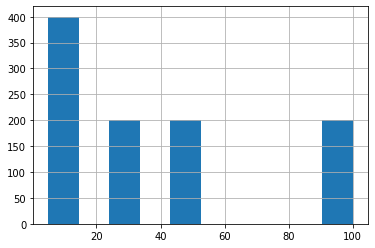

CPU times: user 176 ms, sys: 3.6 ms, total: 180 ms
Wall time: 202 ms


In [10]:
%%time

# carregando as imagens para um DATAFRAME
temp = {}
temp['ROTULO'] = [ int( img[1].split('_')[0] ) for img in imgs]
temp['ORIGINAL'] = [img[0] for img in imgs]

df = pd.DataFrame(temp)
df.info()

print('\n')
# DISTRIBUICAO INICIAL DAS CLASSES (A BASE DE TREINO E TESTE DEVEM TER A MESMA DISTRIBUICAO)
df['ROTULO'].hist()
plt.show()

In [11]:
%%time

# BINARY - Imagem binaria

df['BINARY'] = [ img_to_bin(img) for img in df['ORIGINAL']]

print_count(df['BINARY'], df['ORIGINAL'])

Contagem de elementos não nulos: 1000 / 1000

CPU times: user 2min 10s, sys: 1.54 s, total: 2min 11s
Wall time: 2min 11s


In [12]:
%%time

# RECT - Os dois pontos que definem o retangulo
# RECT = x1,y1,x2,y2

df['RECT'] = [ bbox(img) for img in df['BINARY'] ]

print_count(df['RECT'], df['ORIGINAL'])

Contagem de elementos não nulos: 981 / 1000

CPU times: user 3.61 s, sys: 55 ms, total: 3.66 s
Wall time: 3.66 s


In [13]:
%%time

# RECORTE - Recorte do retangulo sobre a imagem ORIGINAL

df['RECORTE'] = [ recortar(x[0],x[1]) for x in list(zip(df['ORIGINAL'], df['RECT']))]

print_count(df['RECORTE'], df['ORIGINAL'])

Contagem de elementos não nulos: 981 / 1000

CPU times: user 4.31 ms, sys: 0 ns, total: 4.31 ms
Wall time: 4.37 ms


In [14]:
%%time

# ROI - Recorte do retangulo sobre a imagem BINARIA

df['ROI'] = [ recortar(x[0],x[1]) for x in list(zip(df['BINARY'], df['RECT']))]

print_count(df['ROI'], df['ORIGINAL'])

Contagem de elementos não nulos: 981 / 1000

CPU times: user 4.73 ms, sys: 0 ns, total: 4.73 ms
Wall time: 4.86 ms


In [15]:
%%time

# TRUE_MASK

df['TRUE_MASK'] = [ get_mask(x[0],x[1],x[2]) for x in list(zip(df['ORIGINAL'], df['RECT'], df['ROI']))]

print_count(df['TRUE_MASK'], df['ORIGINAL'])

Contagem de elementos não nulos: 981 / 1000

CPU times: user 941 ms, sys: 3.12 s, total: 4.06 s
Wall time: 4.05 s


In [16]:
%%time

# RESIZE_ORIGINAL - resize(128,128) da imagem original

df['RESIZE_ORIGINAL'] = [ try_resize(img,DIMENSIONS) for img in df['ORIGINAL'] ]

print_count(df['RESIZE_ORIGINAL'], df['ORIGINAL'])

Contagem de elementos não nulos: 1000 / 1000

CPU times: user 44.3 s, sys: 37 s, total: 1min 21s
Wall time: 41.7 s


In [17]:
%%time

# RESIZE_BIN - resize(128,128) da imagem binaria

df['RESIZE_BIN'] = [ try_resize(img,DIMENSIONS) for img in df['BINARY'] ]

print_count(df['RESIZE_BIN'], df['ORIGINAL'])

Contagem de elementos não nulos: 1000 / 1000

CPU times: user 14.6 s, sys: 12 s, total: 26.6 s
Wall time: 13.6 s


In [18]:
%%time

# RESIZE_MASK - resize(128,128) da imagem da mascara
# Tem tratamento diferente pois deve aceitar input das linhas que nao possuem mascara

df['RESIZE_MASK'] = [ try_resize(img,DIMENSIONS) for img in df['TRUE_MASK'] ]

print_count(df['RESIZE_MASK'], df['ORIGINAL'])

Contagem de elementos não nulos: 981 / 1000

CPU times: user 15.1 s, sys: 12.4 s, total: 27.5 s
Wall time: 14 s


In [19]:
df.drop( df[df['RECT'].isna()].index, inplace=True )

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ROTULO           981 non-null    int64 
 1   ORIGINAL         981 non-null    object
 2   BINARY           981 non-null    object
 3   RECT             981 non-null    object
 4   RECORTE          981 non-null    object
 5   ROI              981 non-null    object
 6   TRUE_MASK        981 non-null    object
 7   RESIZE_ORIGINAL  981 non-null    object
 8   RESIZE_BIN       981 non-null    object
 9   RESIZE_MASK      981 non-null    object
dtypes: int64(1), object(9)
memory usage: 84.3+ KB


In [21]:
df.head(5)

,ROTULO,ORIGINAL,BINARY,RECT,RECORTE,ROI,TRUE_MASK,RESIZE_ORIGINAL,RESIZE_BIN,RESIZE_MASK
0,25,"[[[92, 98, 88], [93, 99, 89], [93, 99, 89], [9...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(387, 493, 460, 567)","[[[122, 127, 121], [122, 127, 121], [123, 128,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.3607843137254902, 0.38431372549019605, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,5,"[[[70, 72, 69], [72, 74, 71], [73, 75, 70], [7...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(0, 326, 62, 397)","[[[68, 33, 14], [65, 20, 1], [67, 22, 0], [63,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.27058823529411763, 0.28627450980392155, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,50,"[[[82, 84, 73], [82, 84, 73], [82, 84, 73], [8...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(23, 328, 97, 398)","[[[136, 133, 128], [137, 133, 130], [138, 133,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.32156862745098036, 0.33333333333333315, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,25,"[[[107, 112, 108], [108, 113, 109], [109, 114,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(178, 22, 256, 100)","[[[148, 153, 156], [147, 153, 153], [148, 154,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.4274509803921566, 0.4470588235294115, 0.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,100,"[[[73, 81, 68], [74, 82, 69], [76, 84, 71], [7...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(14, 547, 90, 618)","[[[132, 129, 120], [132, 129, 120], [132, 129,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.29558823529411826, 0.32696078431372605, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [22]:
from sklearn.model_selection import train_test_split

y = df.pop('ROTULO')
X = df

X_train,X_test,y_train,y_test = train_test_split(X.index,
                                                 y,
                                                 stratify = y,
                                                 test_size = 0.3)
X.loc[X_train] # return dataframe train

,ORIGINAL,BINARY,RECT,RECORTE,ROI,TRUE_MASK,RESIZE_ORIGINAL,RESIZE_BIN,RESIZE_MASK
743,"[[[99, 105, 95], [99, 105, 95], [100, 106, 96]...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(64, 229, 126, 293)","[[[136, 135, 131], [136, 135, 131], [136, 136,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.3921568627450978, 0.41568627450980367, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
413,"[[[85, 91, 87], [87, 93, 89], [91, 97, 93], [9...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(115, 285, 193, 363)","[[[130, 134, 135], [130, 136, 136], [131, 137,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.352941176470588, 0.37647058823529395, 0.3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
22,"[[[115, 118, 111], [116, 119, 112], [117, 120,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","(115, 48, 148, 79)","[[[155, 156, 158], [155, 156, 158], [156, 157,...","[[0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.45882352941176446, 0.47058823529411764, 0...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
365,"[[[0, 3, 0], [1, 0, 5], [2, 0, 23], [0, 6, 42]...","[[255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0...","(141, 319, 208, 386)","[[[137, 139, 134], [137, 139, 136], [137, 139,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.04460784313725423, 0.060294117647057624, ...","[[0.894117647058827, 0.10196078431373243, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
326,"[[[75, 77, 72], [76, 78, 73], [77, 80, 73], [7...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(267, 272, 341, 341)","[[[126, 129, 134], [127, 130, 135], [128, 131,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.2980392156862743, 0.30980392156862724, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...
155,"[[[76, 83, 75], [76, 83, 75], [77, 84, 76], [7...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(72, 454, 151, 530)","[[[130, 130, 122], [131, 131, 123], [128, 128,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.30588235294117627, 0.3333333333333331, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
591,"[[[98, 101, 94], [99, 102, 95], [100, 103, 96]...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(387, 163, 463, 241)","[[[137, 138, 140], [137, 138, 140], [137, 138,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.39215686274509787, 0.4039215686274509, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
606,"[[[103, 106, 99], [104, 107, 100], [105, 108, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(241, 259, 313, 325)","[[[144, 143, 149], [144, 143, 149], [145, 144,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.4132352941176476, 0.4235294117647056, 0.3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
737,"[[[99, 102, 93], [100, 103, 94], [100, 103, 94...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(384, 80, 449, 148)","[[[132, 137, 141], [134, 138, 139], [134, 139,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.38823529411764707, 0.403921568627451, 0.3...",

(<matplotlib.axes._subplots.AxesSubplot at 0x7f986818f9d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f986818f9d0>)

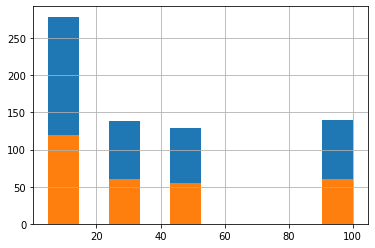

In [23]:
# DISTRIBUICAO DAS CLASSES NAS BASES DE TESTE DE TREINO
y_train.hist(), y_test.hist()

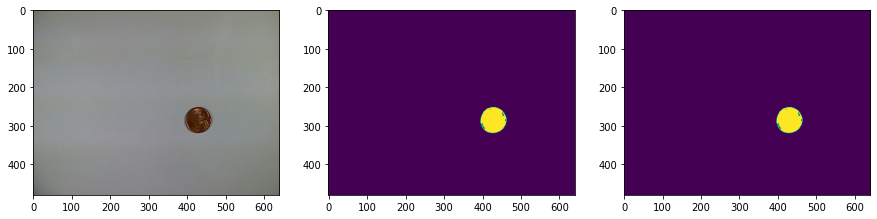

In [24]:
import random

exemplo = df.iloc[random.randint(0,999)]

# PODE DAR ERRADO (PROBABILIDADE DE DAR ERRADO = 19/1000)
plt.figure( figsize=(15,45) )
for i,column in zip( range(3), ['ORIGINAL', 'BINARY', 'TRUE_MASK'] ):
    ax = plt.subplot(1, 3, i+1)
    plt.imshow(exemplo[column])
plt.show()

### Segmentacao (Inicio)

In [25]:
#selecionando casos que possuem mascara
def selectWithMask(X):
  features = X
  hasRECT = features[features['RESIZE_MASK'].notna()]
  return hasRECT

X_trainWithMask = selectWithMask(X.loc[X_train])
X_testWithMask = selectWithMask(X.loc[X_test])
y_trainWithMask = X_trainWithMask["RESIZE_MASK"]
y_testWithMask = X_testWithMask["RESIZE_MASK"]

X_trainWithMask = X_trainWithMask["RESIZE_ORIGINAL"]
X_testWithMask = X_testWithMask["RESIZE_ORIGINAL"]

def selectWithOUTMask(X):
  features = X
  donthasRECT = features[features['RESIZE_MASK'].isna()]
  return donthasRECT

X_trainWithOUTMask = selectWithOUTMask(X.loc[X_train])
X_testWithOUTMask = selectWithOUTMask(X.loc[X_test])
y_trainWithOUTMask = X_trainWithOUTMask["RESIZE_MASK"]
y_testWithOUTMask = X_testWithOUTMask["RESIZE_MASK"]

X_trainWithOUTMask = X_trainWithOUTMask["RESIZE_ORIGINAL"]
X_testWithOUTMask = X_testWithOUTMask["RESIZE_ORIGINAL"]

### Segmentacao (Treino)

In [26]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [27]:
im_height, im_width = (128,128)#dimensions
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [28]:
X_trainWithMask_tf = tf.convert_to_tensor(X_trainWithMask.values.tolist())
y_trainWithMask_tf = tf.convert_to_tensor(y_trainWithMask.values.tolist())
X_testWithMask_tf = tf.convert_to_tensor(X_testWithMask.values.tolist())
y_testWithMask_tf = tf.convert_to_tensor(y_testWithMask.values.tolist())

In [29]:
X_trainWithMask_tf[:2]

<tf.Tensor: shape=(2, 128, 128, 3), dtype=float64, numpy=
array([[[[0.39215686, 0.41568627, 0.37647059],
         [0.40147059, 0.425     , 0.38431373],
         [0.41323529, 0.43676471, 0.39215686],
         ...,
         [0.49411765, 0.50196078, 0.44705882],
         [0.49019608, 0.49803922, 0.44313725],
         [0.48235294, 0.49019608, 0.43529412]],

        [[0.39607843, 0.41960784, 0.37647059],
         [0.40441176, 0.42794118, 0.38823529],
         [0.41960784, 0.44313725, 0.39656863],
         ...,
         [0.49803922, 0.50196078, 0.44705882],
         [0.49019608, 0.49803922, 0.44313725],
         [0.48284314, 0.49068627, 0.43921569]],

        [[0.40343137, 0.42696078, 0.38431373],
         [0.41127451, 0.43480392, 0.39558824],
         [0.42303922, 0.44313725, 0.40735294],
         ...,
         [0.49803922, 0.50588235, 0.45098039],
         [0.49411765, 0.50196078, 0.44705882],
         [0.48627451, 0.49411765, 0.44313725]],

        ...,

        [[0.36470588, 0.36862745, 

In [30]:
y_trainWithMask_tf[:2]

<tf.Tensor: shape=(2, 128, 128), dtype=float64, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])>

In [31]:
results = model.fit(X_trainWithMask_tf, y_trainWithMask_tf, batch_size=32, epochs=10, callbacks=callbacks,\
                    validation_data=(X_testWithMask_tf, y_testWithMask_tf))

Epoch 1/10
22/22 [==============================] - 85s 4s/step - loss: 0.4872 - accuracy: 0.9172 - val_loss: 0.3760 - val_accuracy: 0.9798

Epoch 00001: val_loss improved from inf to 0.37599, saving model to model-tgs-salt.h5
Epoch 2/10
22/22 [==============================] - 82s 4s/step - loss: 0.3137 - accuracy: 0.9826 - val_loss: 0.4227 - val_accuracy: 0.9791

Epoch 00002: val_loss did not improve from 0.37599
Epoch 3/10
22/22 [==============================] - 81s 4s/step - loss: 0.2450 - accuracy: 0.9828 - val_loss: 0.4262 - val_accuracy: 0.9672

Epoch 00003: val_loss did not improve from 0.37599
Epoch 4/10
22/22 [==============================] - 82s 4s/step - loss: 0.2011 - accuracy: 0.9829 - val_loss: 0.2173 - val_accuracy: 0.9806

Epoch 00004: val_loss improved from 0.37599 to 0.21730, saving model to model-tgs-salt.h5
Epoch 5/10
22/22 [==============================] - 82s 4s/step - loss: 0.1687 - accuracy: 0.9829 - val_loss: 0.1778 - val_accuracy: 0.9802

Epoch 00005: val_

In [32]:
results

### Classificador

In [35]:
predicted_masks_train = model.predict(tf.convert_to_tensor( X.loc[X_train]["RESIZE_ORIGINAL"].values.tolist() )) 
predicted_masks_test = model.predict(tf.convert_to_tensor( X.loc[X_test]["RESIZE_ORIGINAL"].values.tolist() ))

bin_train = [ np.where(i > 0.014, 1, 0) for i in predicted_masks_train ]
bin_test = [ np.where(i > 0.014, 1, 0) for i in predicted_masks_test ]

lim_train = [ bbox(img) for img in bin_train ]
lim_test = [ bbox(img) for img in bin_test ]

recortes_train = [ recortar(x[0], x[1]) for x in zip(df['RESIZE_ORIGINAL'], pd.DataFrame(lim_train)) ]
recortes_test = [ recortar(x[0], x[1]) for x in zip(df['RESIZE_ORIGINAL'], pd.DataFrame(lim_test)) ]

def getBinaryLabel(value):
  res = [0,0,0,0,0]
  if value == 5:
    res[0] = 1
  elif value == 10:
    res[1] = 1
  elif value == 25:
    res[2] = 1
  elif value == 50:
    res[3] = 1
  else:
    res[4] = 1

  return res

reshape1 = np.array([a.reshape(a.shape[0], a.shape[1], -1) for a in X.loc[X_train]["RESIZE_ORIGINAL"].values.tolist()])
reshape2 = np.array([a.reshape(a.shape[0], a.shape[1], -1) for a in X.loc[X_test]["RESIZE_ORIGINAL"].values.tolist()])

#training_data = tf.convert_to_tensor(X.loc[X_train]["RESIZE_ORIGINAL"].values.tolist())
training_data = tf.convert_to_tensor( reshape1 )
training_value = tf.convert_to_tensor([getBinaryLabel(int(yy)) for yy in y.loc[X_train].values.tolist()])
#testing_data = tf.convert_to_tensor(X.loc[X_test]["RESIZE_ORIGINAL"].values.tolist())
testing_data = tf.convert_to_tensor( reshape2 )
testing_value = tf.convert_to_tensor([getBinaryLabel(int(yy)) for yy in y.loc[X_test].values.tolist()])

In [36]:

from tensorflow.keras import datasets, layers, models

Classifier = models.Sequential()
Classifier.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
Classifier.add(layers.Conv2D(64, (3, 3), activation='relu'))
Classifier.add(layers.Conv2D(64, (3, 3), activation='relu'))
Classifier.add(layers.Flatten())
Classifier.add(layers.Dense(10, activation='relu'))
Classifier.add(layers.Dense(5, activation='sigmoid'))

In [37]:
histories = []
optimizers = ["adamax"]#,"adam","adadelta","adagrad","nadam","ftrl","rmsprop","sgd"]
losses = ["categorical_crossentropy"]#,"binary_crossentropy","poisson","binary_crossentropy"]
for opt in optimizers:
  for los in losses:
    Classifier.compile(optimizer=opt
              ,loss=los#'categorical_crossentropy'#tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy']
              )

    history = Classifier.fit(training_data, training_value,  
                    epochs=10, 
                    validation_data=(testing_data, testing_value)
                    )
  
    histories.append(history)

Epoch 1/10
22/22 [==============================] - 91s 4s/step - loss: 2.7540 - accuracy: 0.2012 - val_loss: 1.6095 - val_accuracy: 0.2034
Epoch 2/10
22/22 [==============================] - 89s 4s/step - loss: 1.6095 - accuracy: 0.2041 - val_loss: 1.6094 - val_accuracy: 0.2034
Epoch 3/10
22/22 [==============================] - 89s 4s/step - loss: 1.6094 - accuracy: 0.1837 - val_loss: 1.6094 - val_accuracy: 0.2034
Epoch 4/10
22/22 [==============================] - 89s 4s/step - loss: 1.6094 - accuracy: 0.1910 - val_loss: 1.6094 - val_accuracy: 0.2034
Epoch 5/10
22/22 [==============================] - 89s 4s/step - loss: 1.6094 - accuracy: 0.2041 - val_loss: 1.6094 - val_accuracy: 0.2034
Epoch 6/10
22/22 [==============================] - 90s 4s/step - loss: 1.6094 - accuracy: 0.2041 - val_loss: 1.6094 - val_accuracy: 0.2034
Epoch 7/10
22/22 [==============================] - 89s 4s/step - loss: 1.6094 - accuracy: 0.2041 - val_loss: 1.6093 - val_accuracy: 0.2034
Epoch 8/10
22/22 [==

10/10 - 9s - loss: 1.6093 - accuracy: 0.2034


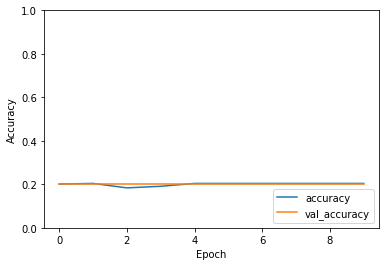

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = Classifier.evaluate(testing_data,  testing_value, verbose=2)

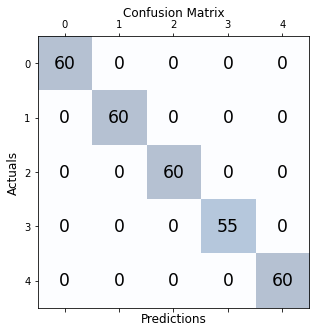

In [62]:
from sklearn.metrics import confusion_matrix

def getBinaryLabelTONUMBER(value):
  if value[0] == 1:
    return 5
  elif value[1] == 1:
    return 10
  elif value[2] == 1:
    return 25
  elif value[3] == 1:
    return 50
  else:
    return 100

testing_value_labels = [ getBinaryLabelTONUMBER(x) for x in testing_value ]
y_pred = Classifier.predict(testing_data,batch_size=32)

y_classes = y_test #y_pred.argmax(axis=-1)
conf_matrix = confusion_matrix(y_true=y_classes, y_pred=testing_value_labels)

#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show()

## Comentários

Comparado à entrega do TDE 1, foi alterada a função de bbox para ser utilizada para imagens sem resize, já que assim a quantidade de imagens cujas moedas foram encontrada melhorou. \
 \
O modelo de segmentação utilizado foi a Unet, que possui uma sequencia de convoluções e conecções residuais, a taxonomia da rede é semelhante ao uso de encoder decoder, sendo que o encoder realiza convoluções e maxpooling em sequencia e o decoder utiliza transpose e convoluções em sequencia. \
 \
O output da rede é uma escala, dado que a função de ativação é sigmoid. \
 \
O modelo de classificação utilizado é tambem separado em duas partes, a primeira parte com camadas de convolução para filtrar as informações importantes da imagem e a segunda parte as camadas dense que agregam as informações locais da image.